<a href="https://colab.research.google.com/github/masoud-moghini/PyTorch-Computer-Vision-Cookbook/blob/master/chapter9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
import cv2
import numpy as np
from random import randint
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import logging
from glob import glob
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.FileHandler('app.log'), logging.StreamHandler()])
logger = logging.getLogger(__name__)

In [ ]:
tfms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [ ]:
class SegData(Dataset):
  def __init__(self, split):
    self.items= glob(f'/content/drive/MyDrive/semanticsegmentation/{split}/img/*')
    self.split = split

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    stem = Path(self.items[idx]).stem
    img = cv2.imread(f'/content/drive/MyDrive/semanticsegmentation/{self.split}/img/{stem}.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(f'/content/drive/MyDrive/semanticsegmentation/{self.split}/label/{stem}.png')
    mask = cv2.resize(mask,(224,224))
    mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
    return img,mask
  def choose(self): return self[randint(len(self))]
  def collate_fn(self,batch):
    imgs,masks = list(zip(*batch))
    imgs = torch.cat([tfms(img.copy()/255)[None] for img in imgs])
    masks = torch.cat([tfms(mask.copy()/255)[None] for mask in masks])
    return imgs,masks

In [ ]:
trn_ds = SegData('train')
val_ds = SegData('val')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True,collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True,collate_fn=val_ds.collate_fn)

In [ ]:
def conv(in_channels, out_channels, kernel_size=3, stride=1):
    return torch.nn.Sequential( torch.nn.Conv2d(
        in_channels, out_channels, kernel_size,stride),
                                 torch.nn.BatchNorm2d(out_channels),
                                 torch.nn.ReLU(inplace = True)
                                 )


def up_conv(in_channels, out_channels, kernel_size=2, stride=2):
    return torch.nn.Sequential(
        torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,stride),
                                 torch.nn.ReLU(inplace = True)
                              )

In [ ]:
from torchvision.models import vgg16_bn

class UNet(nn.Module):
  def __init__(self, pretrained=True, out_channels=12):
    super().__init__()
    self.encoder = vgg16_bn(pretrained=pretrained).features
    self.block1 = nn.Sequential(*self.encoder[:6])
    self.block2 = nn.Sequential(*self.encoder[6:13])
    self.block3 = nn.Sequential(*self.encoder[13:20])
    self.block4 = nn.Sequential(*self.encoder[20:27])
    self.block5 = nn.Sequential(*self.encoder[27:34])

    self.bottleneck = nn.Sequential(*self.encoder[34:])
    self.conv_bottleneck = conv(512,1024)


    self.up_conv6 = up_conv(1024,512)
    self.conv6 = conv(512 + 512,512)
    self.up_conv7 = up_conv(512,256)
    self.conv7 = conv(256 + 256,256)
    self.up_conv8 = up_conv(256,128)
    self.conv8 = conv(128 + 128,128)
    self.up_conv9 = up_conv(128,64)
    self.conv9 = conv(64 + 64,64)
    self.up_conv10 = up_conv(64,32)
    self.conv10 = conv(32 + 32,32)
    self.conv11 = nn.Conv2d(32,out_channels,kernel_size=1)

  def forward(self,x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    bottleneck = self.bottleneck(block5)
    x = self.conv_bottleneck(bottleneck)

    x = self.up_conv6(x)
    x = self.conv6(torch.cat([x,block5]))

    x = self.up_conv7(x)
    x = self.conv7(torch.cat([x,block4]))

    x = self.up_conv8(x)
    x = self.conv8(torch.cat([x,block3]))

    x = self.up_conv9(x)
    x = self.conv9(torch.cat([x,block2]))

    x = self.up_conv10(x)
    x = self.conv10(torch.cat([x,block1]))

    x = self.conv11(x)
    return x



In [ ]:
ce = nn.CrossEntropyLoss()
def UnetLoss(pred,target):
  ce_loss = ce(pred,target)
  acc = (torch.max(pred,dim=1)[1] == target).float().mean()
  return ce_loss,acc

In [ ]:
def train_batch(data,model,optimizer,criterion):
  model.train()
  imgs,masks = data
  _masks = model(imgs)
  optimizer.zero_grad()
  ce_loss,accs = criterion(_masks,masks)
  ce_loss.backward()
  optimizer.step()
  return ce_loss.item(),accs.item()

@torch.no_grad()
def validate_batch(data,model,criterion):
  model.eval()
  imgs,masks = data
  _masks = model(imgs)
  ce_loss,accs = criterion(_masks,masks)
  ce_loss.backward()
  return ce_loss.item(),accs.item()


In [ ]:
model = UNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,momentum=0.9,weight_decay=0.0005)
n_epochs = 4
train_epoch_accs ,test_epoch_accs,train_epoch_loss,test_epoch_loss = [],[],[],[]
for ex in range(n_epochs):
    N = len(trn_dl)
    train_losses, train_accs = [],[]
    for _,data in enumerate(trn_dl):
        loss, accs = train_batch(data,model, optimizer,UnetLoss)
        train_losses.append(loss)
        train_accs.append(accs)
        logger.info(f'train loss = {loss},train accs is {accs}')

    train_epoch_accs.append(np.mean(train_accs))
    train_epoch_loss.append(np.mean(train_losses))
    N = len(val_dl)
    test_losses,test_accs = []
    for _,data in enumerate(val_dl):
        loss, accs = validate_batch(data,model,UnetLoss)
        test_losses.append(loss)
        test_accs.append(accs)
        logger.info(f'val loss = {loss},train regr_loss is {accs}')


    test_epoch_loss.append(np.mean(test_losses))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[[[-1.6042, -1.6727, -1.6042,  ...,  0.3481,  0.3652,  0.2453],
          [-1.5014, -1.4843, -1.4158,  ...,  0.3481,  0.3652,  0.1254],
          [-1.8439, -1.7754, -1.7069,  ...,  0.3481,  0.3652,  0.0741],
          ...,
          [-1.2274, -1.0733, -0.9363,  ..., -0.9705, -0.9877, -0.8335],
          [-1.0390, -1.1075, -1.2103,  ..., -0.9877, -0.9705, -0.7650],
          [-1.2103, -1.3302, -1.4329,  ..., -0.9363, -0.9363, -0.7479]],

         [[-1.3179, -1.3880, -1.3179,  ...,  0.7829,  0.8004,  0.6954],
          [-1.2129, -1.1954, -1.1254,  ...,  0.7654,  0.7829,  0.7304],
          [-1.5630, -1.4930, -1.4230,  ...,  0.7654,  0.7829,  0.7304],
          ...,
          [-0.7927, -0.6352, -0.4951,  ..., -0.5826, -0.6001, -0.7577],
          [-0.6001, -0.6702, -0.8102,  ..., -0.6001, -0.5826, -0.6877],
          [-0.8102, -0.9328, -1.0378,  ..., -0.5476, -0.5476, -0.6527]],

         [[-1.2293, -1.2990, -1.2293,  ...,  0.5311,  0.5485,  0.5136],
          [-1.1247, -1.1073, -

RuntimeError: Input type (double) and bias type (float) should be the same

# ADE DATASET
## Semantic segmentation using MASK-RCNN

In [1]:
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Preparing metadata (setup.py) ... done


In [15]:
!pip install torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━

In [4]:
import torch, torchvision,cv2,numpy as np
import cv2
from torch_snippets.inspector import inspect
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import Dataset,DataLoader
from engine import train_one_epoch, evaluate
from glob import glob
from pathlib import Path
import utils
import transforms as T
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
!tar -xf /content/drive/MyDrive/ADE20K/images.tar
!tar -xf /content/drive/MyDrive/ADE20K/annotations_instance.tar


In [8]:
all_images = glob('/content/images/training/*')
all_annots = glob('/content/annotations_instance/training/*')

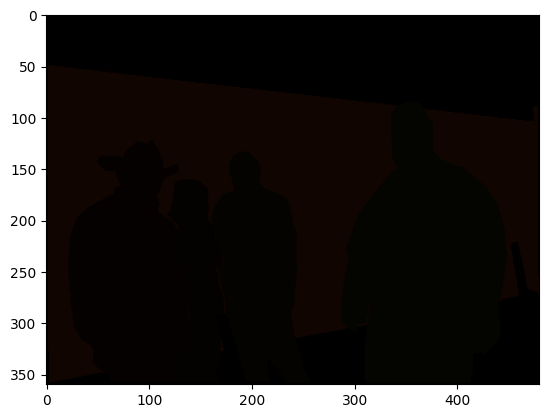

In [9]:
import matplotlib.pyplot as plt
f = 'ADE_train_00014301'

def find(arr,stem):
  for i in arr:
    if Path(i).stem == stem:
      img = cv2.imread(i,cv2.IMREAD_COLOR)
      return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)


im = find(all_images,f)
an = find(all_annots,f)

plt.imshow(an)

an = an.transpose(2,0,1)
r,g,b = an
nzs = np.nonzero(r==4)
instances = np.unique(g[nzs])
masks = np.zeros((len(instances), *r.shape))
for ix,_id in enumerate(instances):
  masks[ix] = g==_id

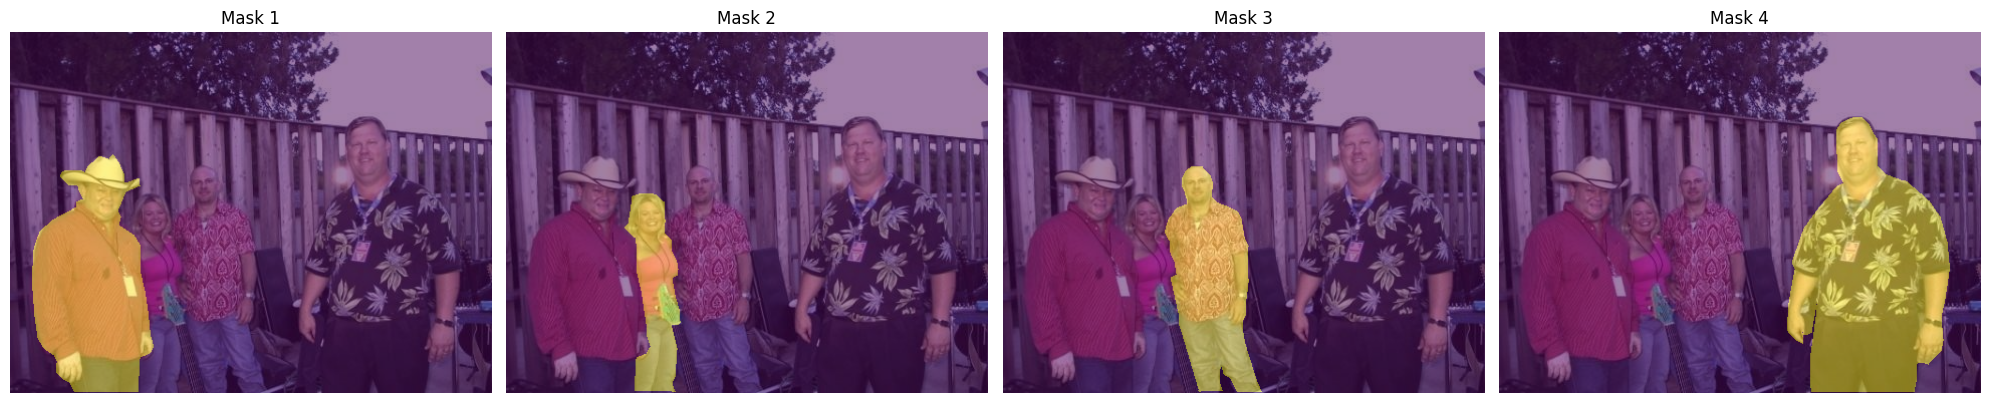

In [10]:
# prompt: draw masks in separate plots using matplotlib

def show_masks(image, masks):
  num_masks = masks.shape[0]
  _, axes = plt.subplots(1, num_masks, figsize=(5 * num_masks, 5))
  if num_masks == 1:
    axes = [axes] # Ensure axes is an iterable for single mask
  for i in range(num_masks):
    axes[i].imshow(image)
    axes[i].imshow(masks[i], alpha=0.5, cmap='viridis') # Use a colormap for masks
    axes[i].set_title(f'Mask {i+1}')
    axes[i].axis('off')
  plt.tight_layout()
  plt.show()

show_masks(im, masks)

In [11]:
annots = []
for idx,an in enumerate(all_annots):
  if idx > 2000:break
  _img = cv2.imread(an,cv2.IMREAD_COLOR)
  _an = cv2.cvtColor(_img,cv2.COLOR_BGR2RGB).transpose(2,0,1)
  r,_,_ = _an
  if 4 not in np.unique(r):continue
  annots.append(an)

In [12]:
from sklearn.model_selection import train_test_split
stems = list(map(lambda fileName: Path(fileName).stem, annots))

In [13]:
trn_items,val_items = train_test_split(stems,random_state=2)

In [14]:
def get_transforms(train):
  transforms = []
  transforms.append(T.PILToTensor())
  if(train):
    transforms.append(T.RandomHorizontalFlip(.5))

  return T.Compose(transforms)

In [62]:
class MaskDataset(Dataset):
  def __init__(self,items,transforms,N):
    self.items = items
    self.transforms = transforms
    self.N = N

  def get_mask(self,path):
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    r,g,b = img.transpose(2,0,1)
    nzs = np.nonzero(r == 4)
    instances = np.unique(g[nzs])
    masks = np.zeros((len(instances),*r.shape))
    for idx,green in enumerate(instances):
      masks[idx] = g == green

    return masks

  def __getitem__(self,ix):
    _id = self.items[ix]
    img_path = f'images/training/{_id}.jpg'
    mask_path = f'annotations_instance/training/{_id}.png'
    masks = self.get_mask(mask_path)
    obj_ids = np.arange(1, len(masks)+1)
    img = Image.open(img_path).convert("RGB")
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      obj_pixels = np.where(masks[i])
      xmin = np.min(obj_pixels[1])
      xmax = np.max(obj_pixels[1])
      ymin = np.min(obj_pixels[0])
      ymax = np.max(obj_pixels[0])
    if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
      xmax = xmin+10
      ymax = ymin+10
    boxes.append([xmin, ymin, xmax, ymax])
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)
    area = (boxes[:, 3] - boxes[:, 1]) *(boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,),dtype=torch.int64)
    image_id = torch.tensor([ix])
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd
    if self.transforms is not None:
      img, target = self.transforms(img, target)
    if (img.dtype == torch.float32) or (img.dtype == torch.uint8) :
      img = img/255.
    return img, target

  def __len__(self):
    return self.N

  def choose(self):
    return self[randint(len(self))]

In [60]:
def describe_tensor(t):
    print(f"Shape: {t.shape}")
    print(f"Data type: {t.dtype}")
    print(f"Device: {t.device}")
    print(f"Requires grad: {t.requires_grad}")
    print(f"Number of elements: {t.numel()}")
    print(f"Rank (dimensions): {t.dim()}")


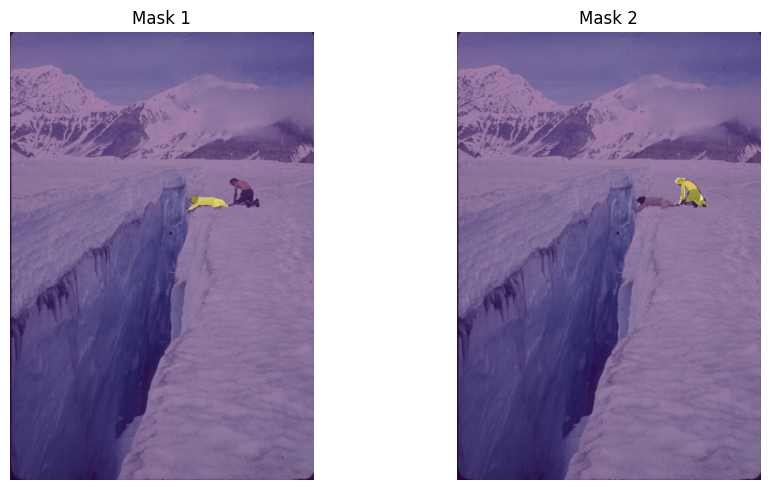

In [67]:
x = MaskDataset(trn_items, get_transforms(train=True),N=100)
im,targ = x[13]

show_masks(np.transpose(im,(1,2,0)), targ['masks'])